In [3]:
import numpy as np

# Generate example time-resolved affinity vector


sub = "sub-RID0143"

# visualize the drops
columns_to_drop = ["ECG01", "ECG02", "EKG01", "EKG02"]

cols = drop_timing_dict[sub].columns

if any(list(map(lambda x: x in columns_to_drop, cols))) == True:
    columns_to_drop = np.array(columns_to_drop)[
        list(map(lambda x: x in cols, columns_to_drop))
    ]
    bool_matrix = drop_timing_dict[sub].drop(columns=columns_to_drop).values.T

    regions = drop_timing_dict[sub].drop(columns=columns_to_drop).columns

    affinity_vector = drop_timing_dict[sub].drop(columns=columns_to_drop).values

else:
    bool_matrix = drop_timing_dict[sub].values.T

    regions = drop_timing_dict[sub].columns

    affinity_vector = drop_timing_dict[sub].values

# Create a list of spike times for each neuron
spike_times = []
for i in range(bool_matrix.shape[0]):
    spike_times.append(np.where(bool_matrix[i, :] == 1)[0])

# Plot the raster plot
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(bool_matrix.shape[0]):
    ax.vlines(spike_times[i], i + 0.5, i + 1.5, color="black")
ax.set_xlim(0, bool_matrix.shape[1])
ax.set_ylim(0.5, bool_matrix.shape[0] + 0.5)
ax.invert_yaxis()
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Electrode")
ax.set_title("Raster Plot")
plt.show()


# define the affinity vector
# List of column names to drop


# Set minimum number of regions exhibiting complexity drop
n = 10


def group_contiguous_numbers(lst):
    result = []
    i = 0
    while i < len(lst):
        j = i + 1
        while j < len(lst) and lst[j] == lst[j - 1] + 1:
            j += 1
        if j - i > 2:
            result.append(list(range(lst[i], lst[j - 1] + 1)))
        else:
            result.append(lst[i] if j - i == 1 else [lst[i], lst[j - 1]])
        i = j
    return result


def identify_drop_cascades(affinity_vector, peak_layer):
    """
    Given an affinity vector and drop windows, identify the peak layer, propagation phase, and fade phase.
    """

    # Initialize directed graph with peak layer as source node
    graph = {peak_layer: []}

    # Perform window-by-window backward and forward search
    prop_phase = []
    drop_count_prop = [sum(affinity_vector[peak_layer])]
    count = 0
    for i in range(peak_layer - 1, -1, -1):  # Backward search
        if np.sum(affinity_vector[i], axis=0) < drop_count_prop[count]:
            prop_phase.append(i)
            drop_count_prop.append(np.sum(affinity_vector[i], axis=0))
            count += 1
        else:
            break

    fade_phase = []
    drop_count_fade = [sum(affinity_vector[peak_layer])]
    count = 0
    for i in range(peak_layer + 1, len(affinity_vector)):  # Forward search
        if np.sum(affinity_vector[i], axis=0) < drop_count_fade[count]:
            fade_phase.append(i)
            drop_count_fade.append(np.sum(affinity_vector[i], axis=0))
            count += 1
        else:
            break

    return peak_layer, prop_phase, fade_phase


# Identify all BOLD windows with at least n regions exhibiting complexity drops
drop_windows = np.where(np.sum(affinity_vector, axis=1) >= n)[0]

if len(drop_windows > 1):
    drop_windows_list = group_contiguous_numbers(drop_windows)
    peak_layer_list = []
    prop_phase_list = []
    fade_phase_list = []
    for i in range(len(drop_windows_list)):
        if isinstance(drop_windows_list[i], (int, np.integer)) == False:
            peak_layer = drop_windows_list[i][
                np.argmax(np.sum(affinity_vector[drop_windows_list[i], :], axis=1))
            ]
        else:
            peak_layer = drop_windows_list[i]

        peak_layer, prop_phase, fade_phase = identify_drop_cascades(
            affinity_vector, peak_layer
        )
        peak_layer_list.append(peak_layer)
        prop_phase_list.append(prop_phase)
        fade_phase_list.append(fade_phase)
else:
    peak_layer = drop_windows[0]
    peak_layer, prop_phase, fade_phase = identify_drop_cascades(
        affinity_vector, peak_layer
    )


def identify_electrodes(affinity_vector, timepoint, region_list):
    return region_list[np.where(affinity_vector[timepoint, :])[0]]


def identify_regions(electrode_names, subject):
    subject_electrodes_metadata = elec_master[elec_master["rid"] == subject]
    subject_electrodes_metadata["name"] = format_elec_names(
        subject_electrodes_metadata["name"].values
    )
    return list(
        np.concatenate(
            list(
                map(
                    lambda x: subject_electrodes_metadata[
                        subject_electrodes_metadata["name"] == x
                    ]["label"].values,
                    electrode_names,
                )
            )
        )
    )

NameError: name 'drop_timing_dict' is not defined

In [ ]:
peak_layer_list, prop_phase_list, fade_phase_list = identify_drop_cascades_all(
    affinity_vector, 10
)

In [ ]:
starting_electrodes = np.concatenate(
    list(
        map(
            lambda x: identify_electrodes(affinity_vector, x[0], regions.values),
            prop_phase_list,
        )
    )
)

In [ ]:
peak_layer_electrodes = np.concatenate(
    list(
        map(
            lambda x: identify_electrodes(affinity_vector, x, regions.values),
            peak_layer_list,
        )
    )
)

In [ ]:
recipient_electrodes = list(set(peak_layer_electrodes) - set(starting_electrodes))

In [ ]:
identify_regions(recipient_electrodes, sub)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['left superior temporal',
 'right inferior temporal',
 'EmptyLabel',
 'left pars orbitalis',
 'left superior temporal',
 'EmptyLabel',
 'right inferior temporal',
 'EmptyLabel',
 'EmptyLabel',
 'left pars opercularis',
 'left precentral',
 'EmptyLabel',
 'left postcentral']

# Repeat the above for all subjects, find the regions most commonly present in the peak layer

Find the peaks

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


def count_duration(arr_of_cluster_numbers):
    components = list(set(list(arr_of_cluster_numbers)))
    duration = []
    for component in components:
        duration.append(np.sum(arr_of_cluster_numbers == component))
    return np.mean(duration)


# this function is needed to match electrode names between iEEG recon and out labels
import re


def fix_old_electrodes(channel_names):
    new_channel_names = []

    # Define a regex pattern to match the relevant components of the name
    pattern = r"^EEG\s(\w{2})\s(\d{2})-Ref$"

    for channel_name in channel_names:
        # Match the pattern against the channel name
        match = re.match(pattern, channel_name)

        if match:
            # Extract the electrode label and number from the regex match
            electrode_label = match.group(1)
            electrode_number = match.group(2)

            # Combine the electrode label and number into the new channel name
            new_channel_names.append(electrode_label + electrode_number)

        else:
            new_channel_names.append(channel_name)

    return new_channel_names


def format_elec_names(names):
    formatted_names = []
    for name in names:
        # split the name into alphabetic and numeric components using regex
        match = re.match(r"([A-Za-z]+)([0-9]+)", name)
        if match:
            alpha, suffix = match.groups()
            # format the suffix with leading zeros and recombine with the alphabetic part
            if suffix.startswith("0"):
                formatted_suffix = suffix
            else:
                formatted_suffix = f"{int(suffix):02d}"
            formatted_name = alpha + formatted_suffix
        else:
            formatted_name = name
        formatted_names.append(formatted_name)
    return fix_old_electrodes(formatted_names)

In [2]:
# master sheet with electrode information
elec_master = pd.read_csv(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/master_elecs.csv"
)

# wpe dictionary
f = open(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/outputs/wpe_broadband2_CAR_w1000_o95_interictal_1_2.p",
    "rb",
)
wpe_dict = pickle.load(f)

exclude_subjects = ["sub-RID0064", "sub-RID0063", "sub-RID0042"]
subjects = list(set(list(wpe_dict.keys())) - set(exclude_subjects))

csv_data = pd.read_csv(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/apn_labels.csv"
)
csv_data[" label"] = list(map(str.lstrip, csv_data[" label"].values))
csv_data[" label"] = list(map(str.rstrip, csv_data[" label"].values))

csv_data.columns = ["index", "label"]

In [3]:
import numpy as np
from scipy.ndimage import label


#### initialize dictionaries
# create the region drop dictionary
region_drop_length_dict = {}
region_drop_dict = {}
region_electrode_name_dict = {}

# spike dictionary
spike_dict = {}

# dictionary to store soz and non-soz labels for each electrode
soz_dict = {}
for region in csv_data["label"].values:
    region_drop_length_dict[region] = []
    region_drop_dict[region] = []
    soz_dict[region] = []
    spike_dict[region] = []
    region_electrode_name_dict[region] = []

region_electrode_name_dict[np.nan] = []
region_drop_length_dict[np.nan] = []
region_drop_dict[np.nan] = []
soz_dict[np.nan] = []
spike_dict[np.nan] = []


# dictionary with drop timing
drop_timing_dict = {}

# iterate through all subjects and save
for subject in subjects:
    wpe_df = wpe_dict[subject]
    # re-format the electrode names
    names = format_elec_names(wpe_df.columns)
    wpe_df.columns = names

    # find the drop count for non-soz electrodes
    sub_elec_metadata = elec_master[elec_master["rid"] == subject]
    sub_elec_metadata["name"] = format_elec_names(sub_elec_metadata["name"].values)

    # define the threshold to determine a drop
    thresh = np.nanpercentile(wpe_df[names].values, 10)

    drop_duration = []
    drop_count = []
    electrode_subject_pair = []
    wpe_drop_df = wpe_df.copy()

    # Compute a binary matrix that has the locations where the drops happened
    for electrode in names:
        # find the location where the WPE is below the threshold
        drop_loc = np.where(wpe_df[electrode].values < thresh)

        # create a binary array to store the drops
        drop_binary = np.zeros(len(wpe_df[electrode].values))
        drop_binary[drop_loc] = 1
        wpe_drop_df[electrode] = drop_binary

        # count the number of  "blobs" in which the signal dropped
        labeled_arr, num_components = label(drop_binary)

        # use this number of blobs as the drop count
        drop_count.append(int(num_components))

        # count the average length/duration of each of the blobs
        drop_duration.append(count_duration(labeled_arr))

        # name the electrode-subject pair
        electrode_subject_pair.append(subject)

    # Normalize the count
    drop_count = drop_count / np.nanmax(drop_count)

    # Normalize the duration
    drop_duration = drop_duration / np.nanmax(drop_duration)

    # save the binary matrix of drop locations
    drop_timing_dict[subject] = wpe_drop_df

    # determine if electrodes were in the soz or not
    soz_ord = list(
        map(
            lambda x: sub_elec_metadata[sub_elec_metadata["name"] == x]["soz"].values,
            names,
        )
    )
    # replace electrodes not found with nan
    soz_ord = list(map(lambda x: x[0] if len(x) == 1 else np.nan, soz_ord))

    # determine the region of the electrode
    label_ord = list(
        map(
            lambda x: sub_elec_metadata[sub_elec_metadata["name"] == x]["label"].values,
            names,
        )
    )
    # replace electrodes not found with nan
    label_ord = list(map(lambda x: x[0] if len(x) == 1 else np.nan, label_ord))

    # determine the spike rate of the electrode
    spike_ord = list(
        map(
            lambda x: sub_elec_metadata[sub_elec_metadata["name"] == x][
                "spike_rate"
            ].values,
            names,
        )
    )
    # replace electrodes not found with nan
    spike_ord = list(map(lambda x: x[0] if len(x) == 1 else np.nan, spike_ord))

    for i in range(len(drop_duration)):
        if soz_ord[i] == True:
            region_drop_length_dict[label_ord[i]].append(drop_duration[i])
            region_drop_dict[label_ord[i]].append(drop_count[i])
            region_electrode_name_dict[label_ord[i]].append(electrode_subject_pair[i])
            soz_dict[label_ord[i]].append("SOZ")
            spike_dict[label_ord[i]].append(spike_ord[i])
        else:
            region_drop_length_dict[label_ord[i]].append(drop_duration[i])
            region_drop_dict[label_ord[i]].append(drop_count[i])
            soz_dict[label_ord[i]].append("non-SOZ")
            spike_dict[label_ord[i]].append(spike_ord[i])
            region_electrode_name_dict[label_ord[i]].append(electrode_subject_pair[i])

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less


Find the propagation of complexity drops

In [159]:
elec_master = pd.read_csv(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/master_elecs_sch200.csv"
)


def group_contiguous_numbers(lst):
    result = []
    i = 0
    while i < len(lst):
        j = i + 1
        while j < len(lst) and lst[j] == lst[j - 1] + 1:
            j += 1
        if j - i > 2:
            result.append(list(range(lst[i], lst[j - 1] + 1)))
        else:
            result.append(lst[i] if j - i == 1 else [lst[i], lst[j - 1]])
        i = j
    return result


def identify_electrodes(affinity_vector, timepoint, region_list):
    return region_list[np.where(affinity_vector[timepoint, :])[0]]


def identify_regions(electrode_names, subject):
    subject_electrodes_metadata = elec_master[elec_master["rid"] == subject]
    subject_electrodes_metadata["name"] = format_elec_names(
        subject_electrodes_metadata["name"].values
    )
    return list(
        np.concatenate(
            list(
                map(
                    lambda x: subject_electrodes_metadata[
                        subject_electrodes_metadata["name"] == x
                    ]["label"].values,
                    electrode_names,
                )
            )
        )
    )


def identify_drop_cascades_all(affinity_vector, n):
    """
    Given an affinity vector and n, identify the peak layers, propagation phases, and fade phases for all BOLD windows
    with at least n regions exhibiting complexity drops.
    """

    def identify_drop_cascades(affinity_vector, peak_layer):
        """
        Given an affinity vector and drop windows, identify the peak layer, propagation phase, and fade phase.
        """

        # Initialize directed graph with peak layer as source node
        graph = {peak_layer: []}

        # Perform window-by-window backward and forward search
        prop_phase = []
        drop_count_prop = [sum(affinity_vector[peak_layer])]
        count = 0
        for i in range(peak_layer - 1, -1, -1):  # Backward search
            if np.sum(affinity_vector[i], axis=0) < drop_count_prop[count]:
                prop_phase.append(i)
                drop_count_prop.append(np.sum(affinity_vector[i], axis=0))
                count += 1
            else:
                break

        fade_phase = []
        drop_count_fade = [sum(affinity_vector[peak_layer])]
        count = 0
        for i in range(peak_layer + 1, len(affinity_vector)):  # Forward search
            if np.sum(affinity_vector[i], axis=0) < drop_count_fade[count]:
                fade_phase.append(i)
                drop_count_fade.append(np.sum(affinity_vector[i], axis=0))
                count += 1
            else:
                break

        return peak_layer, prop_phase, fade_phase

    # Identify all BOLD windows with at least n regions exhibiting complexity drops
    drop_windows = np.where(np.sum(affinity_vector, axis=1) >= n)[0]

    if len(drop_windows > 1):
        drop_windows_list = group_contiguous_numbers(drop_windows)
        peak_layer_list = []
        prop_phase_list = []
        fade_phase_list = []
        for i in range(len(drop_windows_list)):
            if isinstance(drop_windows_list[i], (int, np.integer)) == False:
                peak_layer = drop_windows_list[i][
                    np.argmax(np.sum(affinity_vector[drop_windows_list[i], :], axis=1))
                ]
            else:
                peak_layer = drop_windows_list[i]

            peak_layer, prop_phase, fade_phase = identify_drop_cascades(
                affinity_vector, peak_layer
            )
            peak_layer_list.append(peak_layer)
            prop_phase_list.append(prop_phase)
            fade_phase_list.append(fade_phase)
    else:
        peak_layer = drop_windows[0]
        peak_layer, prop_phase, fade_phase = identify_drop_cascades(
            affinity_vector, peak_layer
        )

    return peak_layer_list, prop_phase_list, fade_phase_list

In [5]:
peak_regions = []
starting_regions = []
all_regions_list = []

# iterate through all subjects

for sub in list(drop_timing_dict.keys()):
    # columns to exclude from the drop propagation calculation - EKG electrodes
    columns_to_drop = [
        "EEG EKG 02-Ref",
        "ECG1",
        "EEG EKG1-Ref",
        "DEC3",
        "LDEC3",
        "EKG2",
        "EKG",
        "EKG1",
        "LDEC4",
        "LDEC2",
        "EKG02",
        "EEG EKG2-Ref",
        "EEG EKG 01-Ref",
        "EEG EKG-Ref",
        "DEC2",
        "DEC4",
        "ECG2",
        "EKG01",
        "LDEC1",
        "DEC1",
    ]

    # extract the name of the electrodes for a given subject
    cols = drop_timing_dict[sub].columns

    # eliminate the EKG columns if present
    if any(list(map(lambda x: x in columns_to_drop, cols))) == True:
        columns_to_drop = np.array(columns_to_drop)[
            list(map(lambda x: x in cols, columns_to_drop))
        ]
        bool_matrix = drop_timing_dict[sub].drop(columns=columns_to_drop).values.T

        regions = drop_timing_dict[sub].drop(columns=columns_to_drop).columns

        affinity_vector = drop_timing_dict[sub].drop(columns=columns_to_drop).values

        # save all of the electrodes for all subjects to normalize by the count later
        all_regions_list.append(
            identify_regions(
                drop_timing_dict[sub].drop(columns=columns_to_drop).columns, sub
            )
        )

    else:
        bool_matrix = drop_timing_dict[sub].values.T

        regions = drop_timing_dict[sub].columns

        affinity_vector = drop_timing_dict[sub].values

        # save all of the electrodes for all subjects to normalize by the count later
        all_regions_list.append(identify_regions(drop_timing_dict[sub].columns, sub))

    # Calculate the peak layer, propagation phase and fade phase electrodes
    peak_layer_list, prop_phase_list, fade_phase_list = identify_drop_cascades_all(
        affinity_vector, 10
    )

    # ignore the first drop cascade (index 0) if it meets the criteria
    if peak_layer_list[0] == 0:
        peak_layer_list = peak_layer_list[1:]
        prop_phase_list = prop_phase_list[1:]
        fade_phase_list = fade_phase_list[1:]

    starting_electrodes = np.concatenate(
        list(
            map(
                lambda x: identify_electrodes(affinity_vector, x[0], regions.values),
                prop_phase_list,
            )
        )
    )
    peak_layer_electrodes = np.concatenate(
        list(
            map(
                lambda x: identify_electrodes(affinity_vector, x, regions.values),
                peak_layer_list,
            )
        )
    )
    recipient_electrodes = list(set(peak_layer_electrodes) - set(starting_electrodes))
    if len(recipient_electrodes) > 0:
        peak_regions.append(identify_regions(recipient_electrodes, sub))
        starting_regions.append(identify_regions(list(set(starting_electrodes)), sub))

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
set(peak_layer_electrodes)

{'CZ',
 'FZ',
 'LA01',
 'LA02',
 'LA05',
 'LA06',
 'LA07',
 'LA08',
 'LA09',
 'LA11',
 'LA12',
 'LB01',
 'LB02',
 'LB03',
 'LB04',
 'LB05',
 'LB06',
 'LB07',
 'LB08',
 'LB09',
 'LB11',
 'LB12',
 'LC01',
 'LC02',
 'LC03',
 'LC04',
 'LC05',
 'LC06',
 'LC07',
 'LC08',
 'LC10',
 'LC11',
 'LC12',
 'LD01',
 'LD02',
 'LD03',
 'LD04',
 'LD05',
 'LD06',
 'LD07',
 'LD08',
 'LE01',
 'LE02',
 'LE03',
 'LE04',
 'LE05',
 'LE06',
 'LE07',
 'LE08',
 'LF01',
 'LF02',
 'LF03',
 'LF04',
 'LF05',
 'LF06',
 'LF07',
 'LG01',
 'LG02',
 'LG03',
 'LG04',
 'LG05',
 'LG07',
 'LG08',
 'LH01',
 'LH02',
 'LH03',
 'LH04',
 'LH05',
 'LH06',
 'LH07',
 'LH08',
 'LH09',
 'LH10',
 'LH11',
 'LH12',
 'LI01',
 'LI02',
 'LI03',
 'LI04',
 'LI05',
 'LI06',
 'LI07',
 'LI08',
 'LK01',
 'LK02',
 'LK03',
 'LK04',
 'LK05',
 'LK06',
 'LK07',
 'LL01',
 'LL02',
 'LL03',
 'LL04',
 'LL05',
 'LL06',
 'LL07',
 'LL08',
 'LL09',
 'LL10',
 'LL11',
 'LL12'}

In [6]:
elec_names = drop_timing_dict[sub].drop(columns=columns_to_drop).columns

In [7]:
all_regions_list

[['EmptyLabel',
  'LH_Default',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'LH_Default',
  'LH_Default',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'LH_Cont',
  'LH_Cont',
  'LH_Cont',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'LH_Default',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'LH_DorsAttn',
  'LH_DorsAttn',
  'LH_DorsAttn',
  'EmptyLabel',
  'EmptyLabel',
  'LH_Vis',
  'LH_Vis',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'LH_Default',
  'LH_Default',
  'LH_Default',
  'LH_Default',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'LH_SalVentAttn',
  'LH_SalVentAttn',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel',
  'EmptyLabel'

In [8]:
identify_regions(elec_names, sub)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'LH_Default',
 'LH_Default',
 'LH_Default',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'LH_Default',
 'LH_Limbic',
 'EmptyLabel',
 'LH_Default',
 'LH_Default',
 'LH_Default',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'LH_Cont',
 'LH_Cont',
 'LH_Default',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'LH_SomMot',
 'LH_SomMot',
 'LH_Default',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'LH_SalVentAttn',
 'LH_SalVentAttn',
 'LH_Default',
 'EmptyLabel',
 'EmptyLabel',
 'LH_SomMot',
 'LH_SomMot',
 'LH_SomMot',
 'LH_SomMot',
 'LH_SomMot',
 'LH_SomMot',
 'LH_SomMot',
 'EmptyLabel',
 'LH_Default',
 'LH_Default',
 'LH_Default',
 'LH_SalVentAttn',
 'LH_SalVentAttn',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLabel',
 'EmptyLab

In [9]:
peak_regions_list = []
for regions in peak_regions:
    peak_regions_list += regions

starting_regions_list = []
for regions in starting_regions:
    starting_regions_list += regions

regions_list = []
for regions in all_regions_list:
    regions_list += regions

In [10]:
df_count = pd.DataFrame()
df_count["Regions"] = peak_regions_list
df_count = df_count[df_count["Regions"] != "EmptyLabel"]
df_count = df_count.groupby("Regions")["Regions"].size().reset_index(name="Count Peak")

In [11]:
df_count_start = pd.DataFrame()
df_count_start["Regions"] = starting_regions_list
df_count_start = df_count_start[df_count_start["Regions"] != "EmptyLabel"]
df_count_start = (
    df_count_start.groupby("Regions")["Regions"].size().reset_index(name="Count Start")
)

In [12]:
df_count_norm = pd.DataFrame()
df_count_norm["Regions"] = regions_list
df_count_norm = df_count_norm[df_count_norm["Regions"] != "EmptyLabel"]
df_count_norm = (
    df_count_norm.groupby("Regions")["Regions"].size().reset_index(name="Count Total")
)

In [13]:
df_count_all = pd.merge(df_count_norm, df_count, on="Regions")

df_count_all = pd.merge(df_count_all, df_count_start, on="Regions")

df_count_all = df_count_all[df_count_all["Count Total"] > 5]

df_count_all["Norm Count Peak"] = (
    df_count_all["Count Peak"] / df_count_all["Count Total"]
)

df_count_all["Norm Count Start"] = (
    df_count_all["Count Start"] / df_count_all["Count Total"]
)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

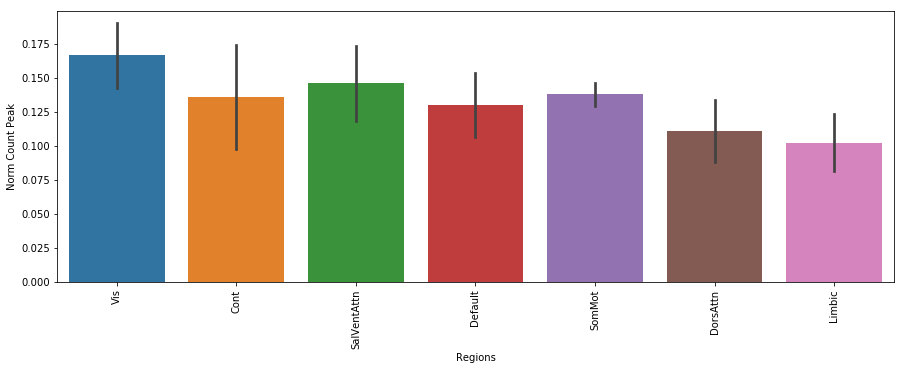

In [14]:
df_count_all = df_count_all.sort_values("Norm Count Peak", ascending=False)

df_count_all["Regions"] = list(
    map(
        lambda x: np.nan if str(x) == "nan" else x.split("_")[1],
        df_count_all["Regions"].values,
    )
)

plt.figure(figsize=(15, 5))
sns.barplot(x="Regions", y="Norm Count Peak", data=df_count_all)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

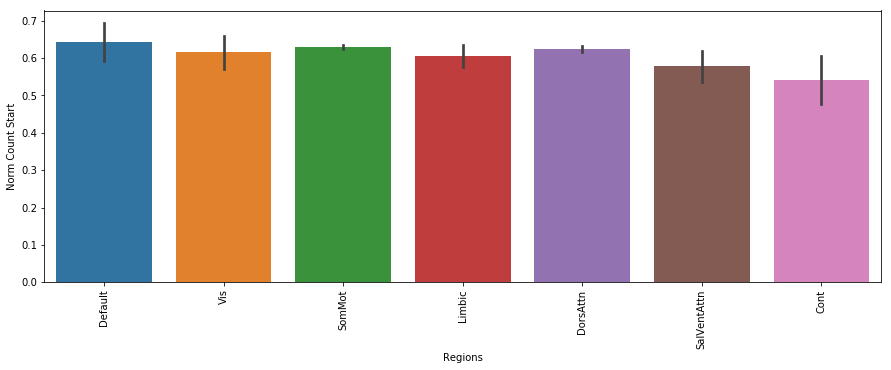

In [15]:
df_count_all = df_count_all.sort_values("Norm Count Start", ascending=False)


plt.figure(figsize=(15, 5))
sns.barplot(x="Regions", y="Norm Count Start", data=df_count_all)
plt.xticks(rotation=90)

## Analysis that calculates the number of times a region starts and peaks per region per subject

The analysis above combines all subjects together. Here we do the analysis on a per-subject basis

In [248]:
peak_regions = []
starting_regions = []
all_regions_list = []

df_count_starting_all = pd.DataFrame(columns=["Region", "Count"])

# iterate through all subjects

for sub in list(drop_timing_dict.keys()):
    # columns to exclude from the drop propagation calculation - EKG electrodes
    columns_to_drop = [
        "EEG EKG 02-Ref",
        "ECG1",
        "EEG EKG1-Ref",
        "DEC3",
        "LDEC3",
        "EKG2",
        "EKG",
        "EKG1",
        "LDEC4",
        "LDEC2",
        "EKG02",
        "EEG EKG2-Ref",
        "EEG EKG 01-Ref",
        "EEG EKG-Ref",
        "DEC2",
        "DEC4",
        "ECG2",
        "EKG01",
        "LDEC1",
        "DEC1",
    ]

    # extract the name of the electrodes for a given subject
    cols = drop_timing_dict[sub].columns

    # eliminate the EKG columns if present
    if any(list(map(lambda x: x in columns_to_drop, cols))) == True:
        columns_to_drop = np.array(columns_to_drop)[
            list(map(lambda x: x in cols, columns_to_drop))
        ]
        bool_matrix = drop_timing_dict[sub].drop(columns=columns_to_drop).values.T

        regions = drop_timing_dict[sub].drop(columns=columns_to_drop).columns

        affinity_vector = drop_timing_dict[sub].drop(columns=columns_to_drop).values

        # save all of the electrodes for all subjects to normalize by the count later
        all_regions_list.append(
            identify_regions(
                drop_timing_dict[sub].drop(columns=columns_to_drop).columns, sub
            )
        )

    else:
        bool_matrix = drop_timing_dict[sub].values.T

        regions = drop_timing_dict[sub].columns

        affinity_vector = drop_timing_dict[sub].values

        # save all of the electrodes for all subjects to normalize by the count later
        all_regions_list.append(identify_regions(drop_timing_dict[sub].columns, sub))

    # Calculate the peak layer, propagation phase and fade phase electrodes
    peak_layer_list, prop_phase_list, fade_phase_list = identify_drop_cascades_all(
        affinity_vector, 10
    )

    # ignore the first drop cascade (index 0) if it meets the criteria
    if peak_layer_list[0] == 0:
        peak_layer_list = peak_layer_list[1:]
        prop_phase_list = prop_phase_list[1:]
        fade_phase_list = fade_phase_list[1:]

    # determine the starting electrodes
    starting_electrodes = list(
        map(
            lambda x: identify_electrodes(affinity_vector, x[0], regions.values),
            prop_phase_list,
        )
    )
    if len(starting_electrodes) > 0:
        df_count_starting_subject = pd.DataFrame()
        df_count_starting_subject["Region"] = np.concatenate(
            list(
                map(
                    lambda x: list(set(identify_regions(x, sub))) if len(x) > 0 else [],
                    starting_electrodes,
                )
            )
        )
        df_count_starting_subject["C"] = 1
        # df_count_starting_subject = df_count_starting_subject[df_count_starting_subject['Region']!='EmptyLabel']
        df_count_starting_subject = (
            df_count_starting_subject.groupby("Region")["C"]
            .size()
            .reset_index(name="Count")
        )

        # normalize the count by the number of propagation waves that take place
        df_count_starting_subject["Count"] = df_count_starting_subject["Count"] / len(
            peak_electrodes
        )
        df_count_starting_subject["Subject"] = sub
        df_count_starting_all = pd.concat(
            [df_count_starting_all, df_count_starting_subject]
        )

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['LA12' 'LA04' 'LA05' 'LA07' 'LA08' 'LB04' 'LB05' 'LB08' 'LB09' 'LC06'
 'LI01']
0     0.488889
1     0.088889
2     0.111111
3     0.111111
4     0.177778
5     0.066667
6     0.355556
7     0.044444
8     0.022222
9     0.022222
10    0.088889
11    0.044444
12    0.066667
Name: Count, dtype: float64
['RDA01' 'RDPS03' 'RG01' 'RG03' 'RG04' 'RG05' 'RG06' 'RG07' 'RG08' 'RG11'
 'RG17' 'RG18' 'RG19' 'RG20' 'RG21' 'RG23' 'RG26' 'RG32' 'RG63' 'RG64']
Series([], Name: Count, dtype: float64)
['LG06' 'LG07' 'LG20' 'LG37' 'LG47' 'LG49' 'LG50' 'EEG LST 02-Ref'
 'EEG RFR 02-Ref']
0     0.466667
1     0.177778
2     0.044444
3     0.111111
4     0.133333
5     0.444444
6     0.400000
7     0.222222
8     0.355556
9     0.044444
10    0.066667
Name: Count, dtype: float64
['EEG AMY 03-Ref' 'EEG G 25-Ref' 'EEG G 30-Ref' 'EEG G 39-Ref'
 'EEG G 41-Ref' 'EEG G 56-Ref' 'EEG G 57-Ref' 'EEG G 63-Ref'
 'EEG HIP 01-Ref' 'EEG HIP 02-Ref' 'EEG HIP 03-Ref']
Series([], Name: Count, dtype: float64)
['LA02' 'LA03' 

['LG01' 'LG12' 'LG18' 'LG02' 'LG35' 'LG04' 'LG49' 'LG50' 'LG53' 'LG54'
 'LG55' 'LG63' 'LG09']
Series([], Name: Count, dtype: float64)
['RD01' 'RD05' 'RD06' 'RM07']
0     0.533333
1     0.022222
2     0.155556
3     0.022222
4     0.022222
5     0.066667
6     0.133333
7     0.066667
8     0.155556
9     0.044444
10    0.022222
11    0.066667
Name: Count, dtype: float64
['LB10' 'LB07' 'LB08' 'LB09' 'LE05' 'LF04' 'LG01' 'LH01' 'LH02' 'LH03'
 'RA03' 'RA04' 'RA07' 'RA08' 'RC08' 'RC09' 'RI06' 'RJ08']
0     0.466667
1     0.244444
2     0.022222
3     0.044444
4     0.177778
5     0.022222
6     0.022222
7     0.044444
8     0.022222
9     0.066667
10    0.222222
11    0.266667
12    0.022222
13    0.022222
14    0.066667
15    0.155556
Name: Count, dtype: float64
['LA02' 'LA03' 'LA04' 'LA05' 'LA06' 'LA07' 'LA08' 'LB10' 'LB11' 'LB12'
 'LB06' 'LB07' 'LB08' 'LC01' 'LC10' 'LC11' 'LC12' 'LC02' 'LC03' 'LC04'
 'LC05' 'LC06' 'LC07' 'LC08' 'LC09' 'LD01' 'LD11' 'LD12' 'LD02' 'LD03'
 'LD04' 'LD06' 'LD

['LL01' 'LL03' 'LL06' 'RG02' 'RG05' 'RG11' 'RG13' 'RG17' 'RG22' 'RG24'
 'RG30' 'RG32' 'RG34' 'EEG RPT 04-Ref' 'EEG RST 04-Ref']
0     0.044444
1     0.177778
2     0.111111
3     0.155556
4     0.200000
5     0.044444
6     0.066667
7     0.288889
8     0.066667
9     0.022222
10    0.066667
11    0.044444
12    0.022222
13    0.200000
14    0.066667
Name: Count, dtype: float64
['LE10' 'LG07' 'LI06' 'LOC' 'RD03']
0     0.666667
1     0.022222
2     0.377778
3     0.022222
4     0.133333
5     0.044444
6     0.155556
7     0.022222
8     0.044444
9     0.622222
10    0.022222
11    0.088889
12    0.066667
Name: Count, dtype: float64
['EEG AOF 01-Ref' 'EEG AOF 02-Ref' 'EEG AOF 03-Ref' 'AS01' 'AS02' 'AS03'
 'AS04' 'HD04' 'EEG POF 02-Ref' 'EEG POF 03-Ref' 'EEG POF 04-Ref'
 'EEG POF 05-Ref' 'EEG POF 06-Ref' 'RG01' 'RG02' 'RG04' 'RG06' 'RG07'
 'RG08' 'RG09' 'RG11' 'RG12' 'RG13' 'RG14' 'RG15' 'RG19' 'RG20' 'RG26'
 'RG28' 'RG33' 'RG34' 'RG35' 'RG37' 'RG38' 'RG41' 'RG42' 'RG43' 'RG44'
 'RG45' '

0    0.488889
1    0.044444
2    0.066667
3    0.066667
4    0.288889
5    0.088889
6    0.022222
7    0.288889
8    0.088889
Name: Count, dtype: float64
['LA01' 'LA05' 'LA06' 'LB05' 'LB06' 'LB07' 'LG01' 'LG02' 'LH05' 'LH06'
 'LH07' 'LH08' 'RE03' 'RE04' 'RE06']
0     0.800000
1     0.022222
2     0.088889
3     0.777778
4     0.022222
5     0.155556
6     0.177778
7     0.044444
8     0.066667
9     0.222222
10    0.066667
11    0.288889
12    0.066667
13    0.066667
14    0.155556
15    0.022222
16    0.044444
17    0.022222
18    0.044444
19    0.088889
Name: Count, dtype: float64
['LA08' 'LB05' 'LE06' 'LE07' 'LE08' 'LH01' 'LH02' 'LH03' 'LJ03' 'LL07'
 'LN06']
Series([], Name: Count, dtype: float64)
['LA01' 'EEG LMPI 01-Ref' 'EEG RSPI 04-Ref']
Series([], Name: Count, dtype: float64)
['LDA06' 'LDC02' 'LDC03' 'LDC04' 'LDC05' 'LDD03' 'LDD04' 'LDE07' 'LDE08'
 'LSZ03']
Series([], Name: Count, dtype: float64)
['EEG LFP 06-Ref' 'LG13' 'LG20' 'LG21' 'LG22' 'LG29' 'LG57' 'LG58'
 'EEG RR-Ref']


In [249]:
df_count_peak_all = pd.DataFrame(columns=["Region", "Count"])

# iterate through all subjects

for sub in list(drop_timing_dict.keys()):
    # columns to exclude from the drop propagation calculation - EKG electrodes
    columns_to_drop = [
        "EEG EKG 02-Ref",
        "ECG1",
        "EEG EKG1-Ref",
        "DEC3",
        "LDEC3",
        "EKG2",
        "EKG",
        "EKG1",
        "LDEC4",
        "LDEC2",
        "EKG02",
        "EEG EKG2-Ref",
        "EEG EKG 01-Ref",
        "EEG EKG-Ref",
        "DEC2",
        "DEC4",
        "ECG2",
        "EKG01",
        "LDEC1",
        "DEC1",
    ]

    # extract the name of the electrodes for a given subject
    cols = drop_timing_dict[sub].columns

    # eliminate the EKG columns if present
    if any(list(map(lambda x: x in columns_to_drop, cols))) == True:
        columns_to_drop = np.array(columns_to_drop)[
            list(map(lambda x: x in cols, columns_to_drop))
        ]
        bool_matrix = drop_timing_dict[sub].drop(columns=columns_to_drop).values.T

        regions = drop_timing_dict[sub].drop(columns=columns_to_drop).columns

        affinity_vector = drop_timing_dict[sub].drop(columns=columns_to_drop).values

        # save all of the electrodes for all subjects to normalize by the count later
        all_regions_list.append(
            identify_regions(
                drop_timing_dict[sub].drop(columns=columns_to_drop).columns, sub
            )
        )

    else:
        bool_matrix = drop_timing_dict[sub].values.T

        regions = drop_timing_dict[sub].columns

        affinity_vector = drop_timing_dict[sub].values

        # save all of the electrodes for all subjects to normalize by the count later
        all_regions_list.append(identify_regions(drop_timing_dict[sub].columns, sub))

    # Calculate the peak layer, propagation phase and fade phase electrodes
    peak_layer_list, prop_phase_list, fade_phase_list = identify_drop_cascades_all(
        affinity_vector, 10
    )

    # ignore the first drop cascade (index 0) if it meets the criteria
    if peak_layer_list[0] == 0:
        peak_layer_list = peak_layer_list[1:]
        prop_phase_list = prop_phase_list[1:]
        fade_phase_list = fade_phase_list[1:]

    # determine the peak electrodes
    peak_electrodes = list(
        map(
            lambda x: identify_electrodes(affinity_vector, x, regions.values),
            peak_layer_list,
        )
    )
    if len(peak_electrodes) > 0:
        df_count_peak_subject = pd.DataFrame()
        df_count_peak_subject["Region"] = np.concatenate(
            list(
                map(
                    lambda x: list(set(identify_regions(x, sub))) if len(x) > 0 else [],
                    peak_electrodes,
                )
            )
        )
        df_count_peak_subject["C"] = 1
        # df_count_peak_subject = df_count_peak_subject[df_count_peak_subject['Region']!='EmptyLabel']
        df_count_peak_subject = (
            df_count_peak_subject.groupby("Region")["C"]
            .size()
            .reset_index(name="Count")
        )

        # normalize the count by the number of propagation waves that take place
        df_count_peak_subject["Count"] = df_count_peak_subject["Count"] / len(
            peak_electrodes
        )
        df_count_peak_subject["Subject"] = sub
        df_count_peak_all = pd.concat([df_count_peak_all, df_count_peak_subject])
        print(df_count_peak_subject["Count"])

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0     1.000000
1     0.173913
2     0.304348
3     0.260870
4     0.478261
5     0.043478
6     0.956522
7     0.391304
8     0.173913
9     0.173913
10    0.434783
11    0.130435
12    0.260870
Name: Count, dtype: float64
Series([], Name: Count, dtype: float64)
0     1.000000
1     0.380952
2     0.047619
3     0.285714
4     0.666667
5     0.952381
6     0.904762
7     0.761905
8     0.857143
9     0.095238
10    0.285714
Name: Count, dtype: float64
Series([], Name: Count, dtype: float64)
0    1.000000
1    0.076923
2    0.179487
3    0.897436
4    0.256410
5    0.128205
6    0.179487
7    0.205128
8    0.512821
9    0.051282
Name: Count, dtype: float64
0     1.00
1     0.70
2     0.15
3     0.25
4     0.25
5     0.30
6     0.20
7     0.60
8     0.45
9     0.65
10    0.55
11    0.25
12    0.25
13    0.50
14    0.30
15    0.50
16    0.55
17    0.70
18    0.65
19    0.45
20    0.85
21    0.50
22    0.25
Name: Count, dtype: float64
0     1.00
1     0.04
2     0.56
3     0.72
4     0.24


0    0.37500
1    0.09375
2    0.06250
3    0.03125
4    0.75000
5    0.40625
6    0.06250
7    0.18750
Name: Count, dtype: float64
0    1.000000
1    0.315789
2    0.052632
3    0.052632
4    0.157895
Name: Count, dtype: float64
Series([], Name: Count, dtype: float64)
0     1.000000
1     0.928571
2     0.428571
3     1.000000
4     0.142857
5     0.142857
6     0.285714
7     0.071429
8     0.071429
9     0.428571
10    1.000000
11    0.285714
12    0.214286
Name: Count, dtype: float64
0     0.153846
1     0.846154
2     0.461538
3     0.461538
4     0.846154
5     0.307692
6     0.153846
7     1.000000
8     0.307692
9     0.230769
10    0.153846
11    0.307692
12    0.230769
13    1.000000
14    0.384615
Name: Count, dtype: float64
0     1.000000
1     0.133333
2     0.866667
3     0.033333
4     0.033333
5     0.300000
6     0.100000
7     0.266667
8     0.066667
9     0.033333
10    0.066667
11    1.000000
12    0.033333
13    0.033333
14    0.166667
15    0.166667
Name: Count, d

In [267]:
df_count_recipient_all = pd.DataFrame(columns=["Region", "Count"])

# iterate through all subjects

for sub in list(drop_timing_dict.keys()):
    # columns to exclude from the drop propagation calculation - EKG electrodes
    columns_to_drop = [
        "EEG EKG 02-Ref",
        "ECG1",
        "EEG EKG1-Ref",
        "DEC3",
        "LDEC3",
        "EKG2",
        "EKG",
        "EKG1",
        "LDEC4",
        "LDEC2",
        "EKG02",
        "EEG EKG2-Ref",
        "EEG EKG 01-Ref",
        "EEG EKG-Ref",
        "DEC2",
        "DEC4",
        "ECG2",
        "EKG01",
        "LDEC1",
        "DEC1",
    ]

    # extract the name of the electrodes for a given subject
    cols = drop_timing_dict[sub].columns

    # eliminate the EKG columns if present
    if any(list(map(lambda x: x in columns_to_drop, cols))) == True:
        columns_to_drop = np.array(columns_to_drop)[
            list(map(lambda x: x in cols, columns_to_drop))
        ]
        bool_matrix = drop_timing_dict[sub].drop(columns=columns_to_drop).values.T

        regions = drop_timing_dict[sub].drop(columns=columns_to_drop).columns

        affinity_vector = drop_timing_dict[sub].drop(columns=columns_to_drop).values

        # save all of the electrodes for all subjects to normalize by the count later
        all_regions_list.append(
            identify_regions(
                drop_timing_dict[sub].drop(columns=columns_to_drop).columns, sub
            )
        )

    else:
        bool_matrix = drop_timing_dict[sub].values.T

        regions = drop_timing_dict[sub].columns

        affinity_vector = drop_timing_dict[sub].values

        # save all of the electrodes for all subjects to normalize by the count later
        all_regions_list.append(identify_regions(drop_timing_dict[sub].columns, sub))

    # Calculate the peak layer, propagation phase and fade phase electrodes
    peak_layer_list, prop_phase_list, fade_phase_list = identify_drop_cascades_all(
        affinity_vector, 10
    )

    # ignore the first drop cascade (index 0) if it meets the criteria
    if peak_layer_list[0] == 0:
        peak_layer_list = peak_layer_list[1:]
        prop_phase_list = prop_phase_list[1:]
        fade_phase_list = fade_phase_list[1:]

    # determine the recipient electrodes - e.g. electrodes that are in the peak layer but not in the start layer
    peak_electrodes = list(
        map(
            lambda x: identify_electrodes(affinity_vector, x, regions.values),
            peak_layer_list,
        )
    )
    starting_electrodes = list(
        map(
            lambda x: identify_electrodes(affinity_vector, x[0], regions.values),
            prop_phase_list,
        )
    )
    recipient_electrodes = list(
        map(
            lambda x, y: list(set(x) - set(y))
            if len(list(set(x) - set(y))) > 0
            else [],
            peak_electrodes,
            starting_electrodes,
        )
    )
    if len(recipient_electrodes) > 0:
        df_count_recipient_subject = pd.DataFrame()
        df_count_recipient_subject["Region"] = np.concatenate(
            list(
                map(
                    lambda x: list(set(identify_regions(x, sub))) if len(x) > 0 else [],
                    recipient_electrodes,
                )
            )
        )
        df_count_recipient_subject["C"] = 1
        # df_count_recipient_subject = df_count_recipient_subject[df_count_recipient_subject['Region']!='EmptyLabel']
        df_count_recipient_subject = (
            df_count_recipient_subject.groupby("Region")["C"]
            .size()
            .reset_index(name="Count")
        )

        # normalize the count by the number of propagation waves that take place
        df_count_recipient_subject["Count"] = df_count_recipient_subject["Count"] / len(
            peak_electrodes
        )
        df_count_recipient_subject["Subject"] = sub
        df_count_recipient_all = pd.concat(
            [df_count_recipient_all, df_count_recipient_subject]
        )

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72]),
 <a list of 73 Text xticklabel objects>)

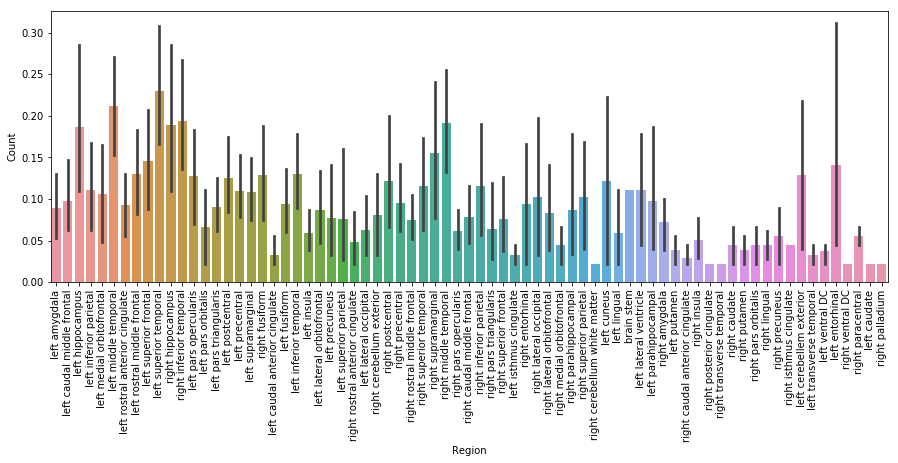

In [268]:
df_count_starting_all = df_count_starting_all[
    df_count_starting_all["Region"] != "EmptyLabel"
]
plt.figure(figsize=(15, 5))
sns.barplot(x="Region", y="Count", data=df_count_starting_all)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73]),
 <a list of 74 Text xticklabel objects>)

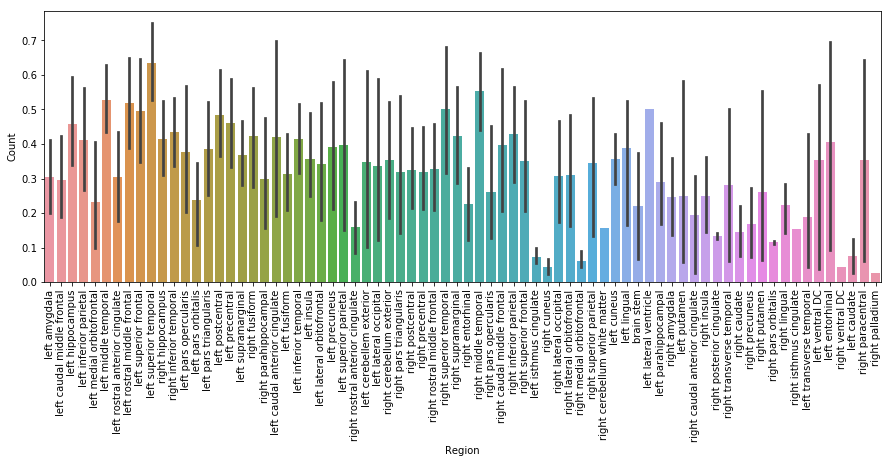

In [269]:
df_count_peak_all = df_count_peak_all[df_count_peak_all["Region"] != "EmptyLabel"]


plt.figure(figsize=(15, 5))
sns.barplot(x="Region", y="Count", data=df_count_peak_all)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70]),
 <a list of 71 Text xticklabel objects>)

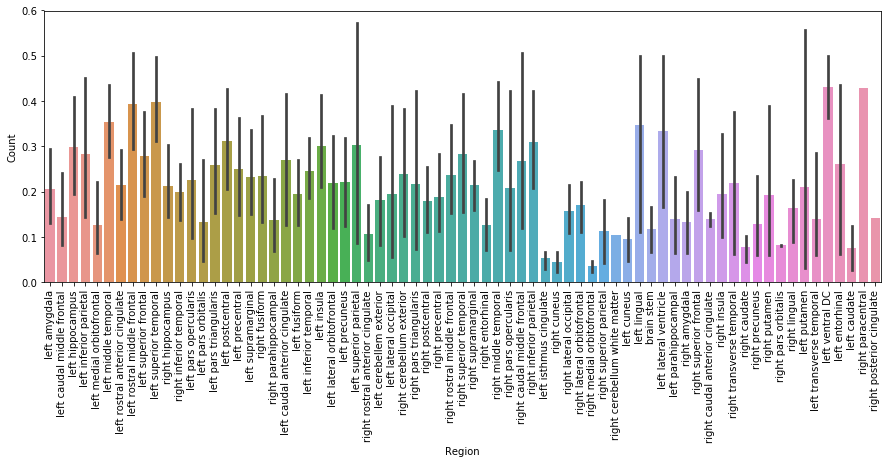

In [270]:
df_count_recipient_all = df_count_recipient_all[
    df_count_recipient_all["Region"] != "EmptyLabel"
]

plt.figure(figsize=(15, 5))
sns.barplot(x="Region", y="Count", data=df_count_recipient_all)
plt.xticks(rotation=90)

In [271]:
df_count_recipient_all["type"] = "recipient"
df_count_starting_all["type"] = "starting"

df_recipient_starting_all = pd.concat([df_count_recipient_all, df_count_starting_all])

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73]),
 <a list of 74 Text xticklabel objects>)

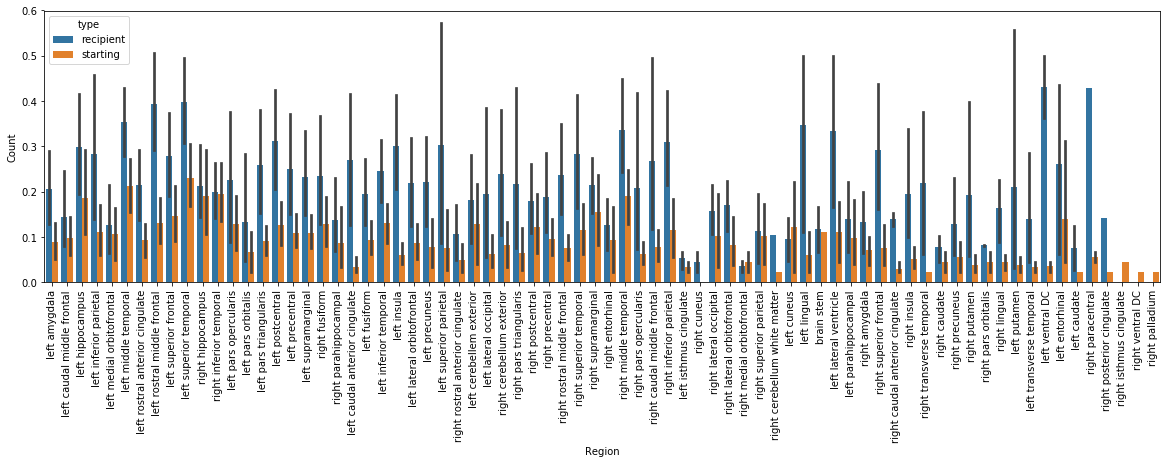

In [273]:
plt.figure(figsize=(20, 5))
sns.barplot(x="Region", y="Count", hue="type", data=df_recipient_starting_all)
plt.xticks(rotation=90)

#### Cohen's d between recipient and starting region count

In [283]:
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size for two groups."""
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_sd = np.sqrt((np.std(group1) ** 2 + np.std(group2) ** 2) / 2)
    return mean_diff / pooled_sd

In [290]:
cohensd_dict = {}

regions = list(set(list(df_count_recipient_all.Region.values)))

for region in regions:
    group1 = df_count_recipient_all[df_count_recipient_all["Region"] == region]["Count"]
    group2 = df_count_starting_all[df_count_starting_all["Region"] == region]["Count"]
    cd = cohens_d(group1, group2)
    if (not np.isinf(cd)) and (not np.isnan(cd)):
        cohensd_dict[region] = cd
    else:
        cohensd_dict[region] = 0

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [317]:
cohensd_dict

{'left amygdala': 0.9522508025835386,
 'right pars triangularis': 0.7189009351718706,
 'right precuneus': 0.9336230306301582,
 'left medial orbitofrontal': 0.2377123777797226,
 'left pars orbitalis': 0.7386081767020508,
 'left rostral anterior cingulate': 1.5543207081694528,
 'right pars orbitalis': 2.3621734206258544,
 'right putamen': 0.9855831926095353,
 'left caudal anterior cingulate': 2.2524571752821565,
 'right inferior temporal': 0.02939787648970903,
 'right superior parietal': 0.13736066448049333,
 'right hippocampus': 0.12625960820354118,
 'left lateral orbitofrontal': 1.1628069327603552,
 'right cerebellum exterior': 1.2692614271293052,
 'right medial orbitofrontal': -0.5147825494911086,
 'left superior parietal': 1.4653543413559904,
 'left caudate': 1.5758379695014488,
 'left rostral middle frontal': 1.3251250467280322,
 'right pars opercularis': 0.7121248967205341,
 'right inferior parietal': 1.2271712258578324,
 'left lateral occipital': 0.7804470394707425,
 'left suprama

## Save values to MNI

#### Save a plot of the recipient count

In [274]:
import nibabel as nib

csv_data = pd.read_csv(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/apn_labels.csv"
)
csv_data[" label"] = list(map(str.lstrip, csv_data[" label"].values))
csv_data[" label"] = list(map(str.rstrip, csv_data[" label"].values))

csv_data.columns = ["index", "label"]

In [275]:
dkt_affine = nib.load(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/dkt_mni.nii.gz"
).affine
dkt_atlas = nib.load(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/dkt_mni.nii.gz"
).get_fdata()

dkt_atlas_recipient_count = np.zeros(dkt_atlas.shape)

In [276]:
# get the mean recipient count
df_count_recipient_all_mean = (
    df_count_recipient_all.groupby("Region")["Count"].mean().reset_index(name="Mean")
)

for region in df_count_recipient_all_mean["Region"].values:
    # get the region index
    region_index = float(csv_data[csv_data["label"] == region]["index"].item())
    dkt_atlas_recipient_count[dkt_atlas == region_index] = df_count_recipient_all_mean[
        df_count_recipient_all_mean["Region"] == region
    ]["Mean"]

In [277]:
nib.save(
    nib.Nifti1Image(dkt_atlas_recipient_count, dkt_affine),
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/outputs/mni_plots/dkt_recipient_count.nii.gz",
)

#### Save a plot of the starting count

In [278]:
dkt_affine = nib.load(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/dkt_mni.nii.gz"
).affine
dkt_atlas = nib.load(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/dkt_mni.nii.gz"
).get_fdata()

dkt_atlas_starting_count = np.zeros(dkt_atlas.shape)

In [279]:
# get the mean starting count
df_count_starting_all_mean = (
    df_count_starting_all.groupby("Region")["Count"].mean().reset_index(name="Mean")
)

for region in df_count_starting_all_mean["Region"].values:
    # get the region index
    region_index = float(csv_data[csv_data["label"] == region]["index"].item())
    dkt_atlas_starting_count[dkt_atlas == region_index] = df_count_starting_all_mean[
        df_count_starting_all_mean["Region"] == region
    ]["Mean"]

In [280]:
nib.save(
    nib.Nifti1Image(dkt_atlas_starting_count, dkt_affine),
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/outputs/mni_plots/dkt_starting_count.nii.gz",
)

#### Save a plot for the Cohen's d

In [313]:
dkt_affine = nib.load(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/dkt_mni.nii.gz"
).affine
dkt_atlas = nib.load(
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/source_data/dkt_mni.nii.gz"
).get_fdata()

dkt_atlas_cohens_d = np.zeros(dkt_atlas.shape)

In [314]:
for region in list(cohensd_dict.keys()):
    # get the region index
    region_index = float(csv_data[csv_data["label"] == region]["index"].item())
    dkt_atlas_cohens_d[dkt_atlas == region_index] = cohensd_dict[region]

In [315]:
nib.save(
    nib.Nifti1Image(dkt_atlas_cohens_d, dkt_affine),
    "/mnt/leif/littlab/users/allucas/CNT_borel/Q6_complexomme/outputs/mni_plots/dkt_cohens_d_starting_recipient.nii.gz",
)

### Visualize drops as a raster plot

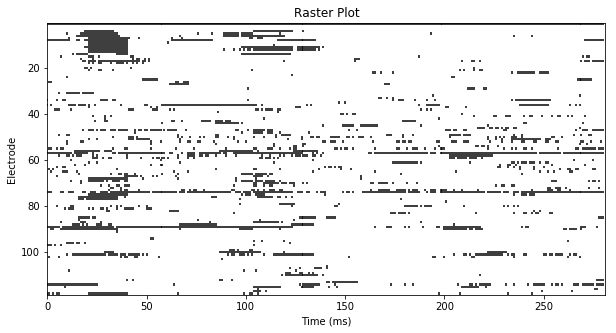

In [171]:
import numpy as np
import matplotlib.pyplot as plt

subject = "sub-RID0190"

# Create a random boolean matrix of shape (num_neurons, num_timepoints)
bool_matrix = drop_timing_dict[subject].values.T

regions = drop_timing_dict[subject].columns

# Create a list of spike times for each neuron
spike_times = []
for i in range(bool_matrix.shape[0]):
    spike_times.append(np.where(bool_matrix[i, :] == 1)[0])

# Plot the raster plot
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(bool_matrix.shape[0]):
    ax.vlines(spike_times[i], i + 0.5, i + 1.5, color="black")
ax.set_xlim(0, bool_matrix.shape[1])
ax.set_ylim(0.5, bool_matrix.shape[0] + 0.5)
ax.invert_yaxis()
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Electrode")
ax.set_title("Raster Plot")
plt.show()